# Data exploration

In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load in days, write unique identifiers for customers because customer 1 on Monday is not the same as customer 1 on Tuesday and add some time variables

In [22]:
monday = pd.read_csv("data/monday.csv", sep=";")
monday["customer_no"] = monday["customer_no"].transform(lambda x: "monday_" + str(x))
tuesday = pd.read_csv("data/tuesday.csv", sep=";")
tuesday["customer_no"] = tuesday["customer_no"].transform(lambda x: "tuesday_" + str(x))
wednesday = pd.read_csv("data/wednesday.csv", sep=";")
wednesday["customer_no"] = wednesday["customer_no"].transform(lambda x: "wednesday_" + str(x))
thursday = pd.read_csv("data/thursday.csv", sep=";")
thursday["customer_no"] = thursday["customer_no"].transform(lambda x: "thursday_" + str(x))
friday = pd.read_csv("data/friday.csv", sep=";")
friday["customer_no"] = friday["customer_no"].transform(lambda x: "friday_" + str(x))
monday.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,monday_1,dairy
1,2019-09-02 07:03:00,monday_2,dairy
2,2019-09-02 07:04:00,monday_3,dairy
3,2019-09-02 07:04:00,monday_4,dairy
4,2019-09-02 07:04:00,monday_5,spices


In [23]:
df = pd.concat([monday, tuesday, wednesday, thursday, friday])
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["week day"] = df["timestamp"].dt.day_name()
df["week day id"] = df["timestamp"].dt.weekday
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df.head()

,timestamp,customer_no,location,week day,week day id,hour,minute
0,2019-09-02 07:03:00,monday_1,dairy,Monday,0,7,3
1,2019-09-02 07:03:00,monday_2,dairy,Monday,0,7,3
2,2019-09-02 07:04:00,monday_3,dairy,Monday,0,7,4
3,2019-09-02 07:04:00,monday_4,dairy,Monday,0,7,4
4,2019-09-02 07:04:00,monday_5,spices,Monday,0,7,4


Q1: Calculate the total number of customers in each section (=location) over time

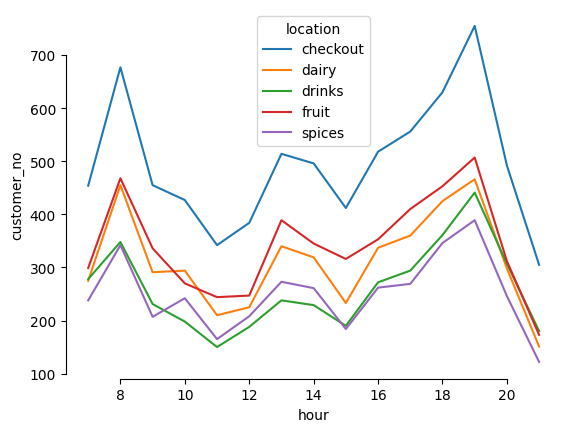

In [24]:
plot_df = df.groupby(["location", "hour"])["customer_no"].count().reset_index()
sns.lineplot(data=plot_df, x="hour", y="customer_no", hue="location")
sns.despine(trim=True)

We can also get it split up by the week days

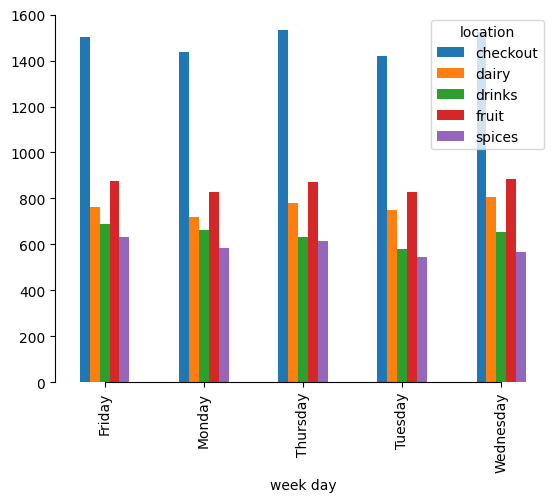

In [25]:
df.groupby(["week day", "location"])["customer_no"].nunique().unstack().plot.bar()
sns.despine(trim=True)

Q2: Display the number of customers at checkout over time

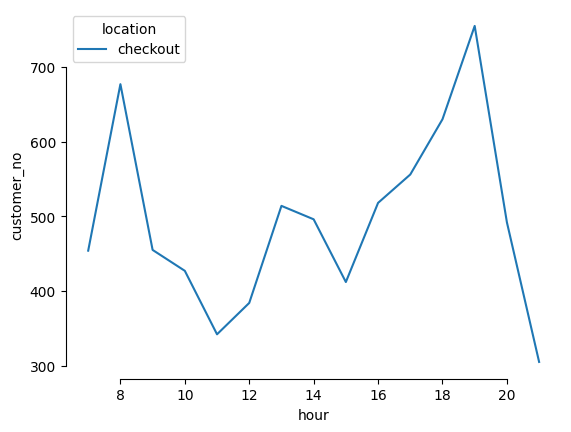

In [26]:
plot_df = df.groupby(["location", "hour"])["customer_no"].count().reset_index()
plot_df = plot_df.loc[plot_df["location"] == "checkout"]
sns.lineplot(data=plot_df, x="hour", y="customer_no", hue="location")
sns.despine(trim=True)

Q3: Calculate the time each customer spent in the market

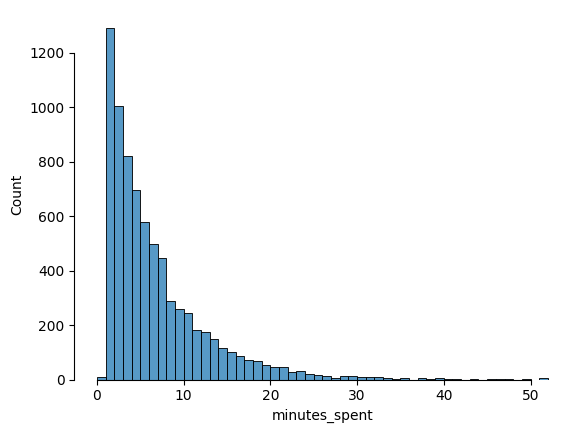

In [27]:
plot_df = (
    df.groupby("customer_no")["timestamp"].max().to_frame()
    - df.groupby("customer_no")["timestamp"].min().to_frame()
).reset_index()
# We can retrieve the total number of minutes as ints from timestamp now, like so
plot_df["minutes_spent"] = plot_df["timestamp"].dt.seconds / 60
sns.histplot(plot_df["minutes_spent"], binwidth=1)
sns.despine(trim=True)

Q4: Calculate the total number of customers in the supermarket over time.

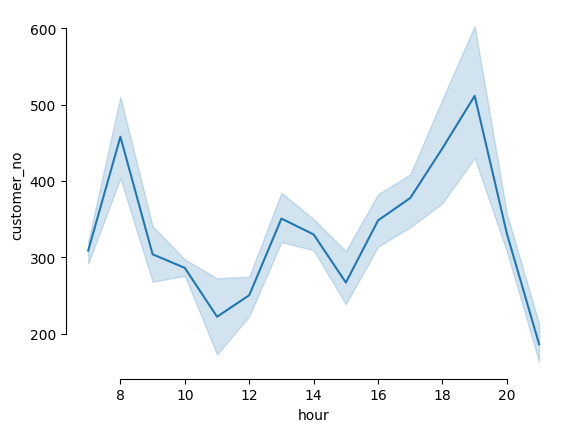

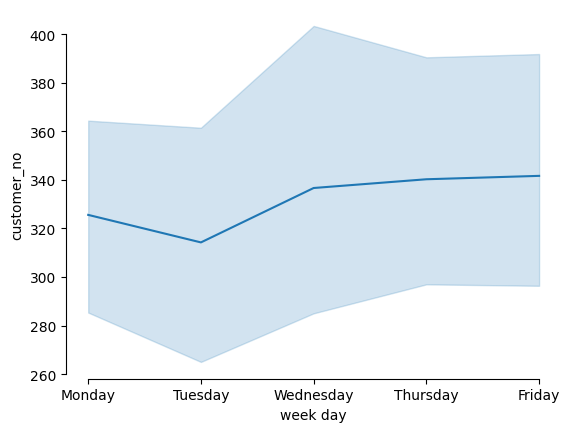

In [28]:
plot_df = (
    df.groupby(["week day", "week day id", "hour"])["customer_no"]
    .count()
    .reset_index()
    .sort_values(by=["week day id", "hour"])
    .drop("week day id", axis=1)
)
# We can now plots this over hours...
plot_df_hours = plot_df.drop("week day", axis=1)
sns.lineplot(data=plot_df_hours, x="hour", y="customer_no")
sns.despine(trim=True)
plt.show()
# or week days...
plot_df_weekdays = plot_df.drop("hour", axis=1)
g = sns.lineplot(data=plot_df_weekdays, x="week day", y="customer_no")
sns.despine(trim=True)
plt.show()

Q5: Our business managers think that the first section customers visit follows a
different pattern than the following ones. Plot the distribution of customers
of their first visited section versus following sections (treat all sections
visited after the first as “following”)
This one is a bit more complex. We use the following approach:
1. We can use pandas .first() method to select the first checkout time point per customer and create a column indexing it as the first time point  
2. We then left-merge the newly create df onto the original df to get the time points that were not selected the first time (i.e., those that were not the first check out time points). This will give us NaNs for those points in our created column.  
3. Then, we can simply fill in the NaNs with "following".  


/var/folders/0c/hjp2h4lx0g52yrgqk3xpnmm40000gn/T/ipykernel_7971/1951637802.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = df.groupby("customer_no")["timestamp", "location"].first().reset_index()


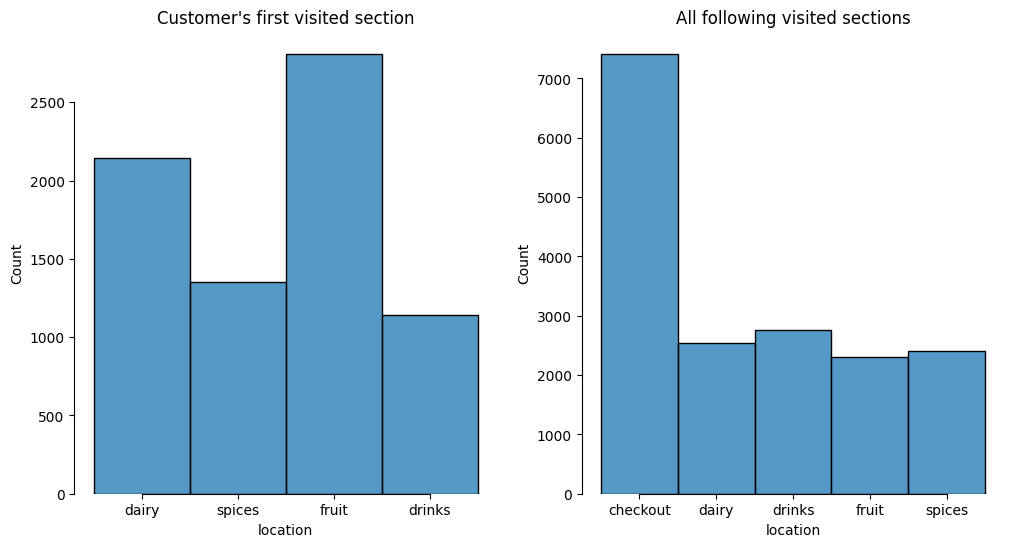

In [29]:
_fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
plot_df = df.groupby("customer_no")["timestamp", "location"].first().reset_index()
plot_df["section_sequence"] = "first"
plot_df = pd.merge(df, plot_df, how="left", on=["customer_no", "timestamp", "location"])
plot_df["section_sequence"] = plot_df["section_sequence"].fillna("following")
sns.histplot(
    data=plot_df, x=plot_df[plot_df.loc[:, "section_sequence"] == "first"]["location"], ax=ax1
)
sns.histplot(
    data=plot_df, x=plot_df[plot_df.loc[:, "section_sequence"] == "following"]["location"], ax=ax2
)
ax1.set_title("Customer's first visited section")
ax2.set_title("All following visited sections")
sns.despine(trim=True)


In [30]:
# Let's store the latest state of the df, so we don't have to build it again:
plot_df.to_csv("data/customer_behavior_allweeks.csv", index=False)